# Documentation

**Author:** Spencer Ressel

**Created:** January 9th, 2024

---

This code analyzes otuput data from Mu-Ting's aquaplanet simulations. The objective is to understand the behavior of the MJO-like mode simulated. 

---

# Imports

In [3]:
print(f"Loading imports...")
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs
# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator
print(f"Imports loaded")
print("===============================================")

Loading imports...
Imports loaded


# Define constants

In [4]:
GRAVITY = 9.81
LATENT_HEAT = 2.26*10**6
SPECIFIC_HEAT = 1004

# Auxiliary functions

In [79]:
def tick_labeller(ticks, direction, degree_symbol=True):
    label = []
    for i in range(len(ticks)):
        if degree_symbol == True:
            if direction=='lon':
                if ticks[i] == 0 or np.abs(ticks[i]) >= 180: 
                    label.append(f"{np.abs(ticks[i])}°")
                elif ticks[i] < 0:
                    label.append(f"{np.abs(ticks[i])}°W")
                elif ticks[i] > 0:
                    label.append(f"{np.abs(ticks[i])}°E")
            elif direction=='lat':
                if ticks[i] == 0:
                    label.append(f"{np.abs(ticks[i])}°")
                elif ticks[i] < 0:
                    label.append(f"{np.abs(ticks[i])}°S")
                elif ticks[i] > 0:
                    label.append(f"{np.abs(ticks[i])}°N")
        else:
            if direction=='lon':
                if ticks[i] == 0 or np.abs(ticks[i]) >= 180: 
                    label.append(f"{np.abs(ticks[i])}")
                elif ticks[i] < 0:
                    label.append(f"{np.abs(ticks[i])}W")
                elif ticks[i] > 0:
                    label.append(f"{np.abs(ticks[i])}E")
            elif direction=='lat':
                if ticks[i] == 0:
                    label.append(f"{np.abs(ticks[i])}")
                elif ticks[i] < 0:
                    label.append(f"{np.abs(ticks[i])}S")
                elif ticks[i] > 0:
                    label.append(f"{np.abs(ticks[i])}N")
    return label

# Load data

In [57]:
data_directory = '/home/disk/eos7/sressel/research/thesis-work/python/GCM_aquaplanet_simulations'
output_file_directory = '/home/disk/eos7/sressel/research/thesis-work/python/GCM_aquaplanet_simulations'
# "thesis-work-link/python/GCM_aquaplanet_simulations/SST_AQP3_Qobs_27_3h_20y.cam.h1.0023-01-31-00000.nc"

print(f"Loading data...")
data = xr.load_dataset(f"{data_directory}/SST_AQP3_Qobs_27_3h_20y.cam.h1.0023-01-31-00000.nc")
large_scale_precipitation = data['PRECL']
convective_precipitation = data['PRECC']
surface_latent_heat_flux = data['LHFLX']
temperature = data['T']
zonal_velocity = data['U']
meridional_velocity = data['V']
geopotential_height = data['Z3']

upper_level_zonal_velocity = zonal_velocity.sel(lev=200, method='nearest')
upper_level_meridional_velocity = meridional_velocity.sel(lev=200, method='nearest')
upper_level_geopotential_height = geopotential_height.sel(lev=200, method='nearest')

lower_level_zonal_velocity = zonal_velocity.sel(lev=850, method='nearest')
lower_level_meridional_velocity = meridional_velocity.sel(lev=850, method='nearest')
lower_level_geopotential_height = geopotential_height.sel(lev=850, method='nearest')

specific_humidity = data['Q']

output_time = data['time']
time = np.arange(0, 3*len(output_time), 3)
pressure_levels = data['lev']
latitude = data['lat']
longitude = data['lon']
print(f"Data loaded")
print("===============================================")

Loading data...
Data loaded


# Calculate column MSE

In [38]:
MSE = GRAVITY*geopotential_height + SPECIFIC_HEAT*temperature + LATENT_HEAT*specific_humidity
column_MSE = -(1/GRAVITY)*MSE.integrate(coord='lev')

# MJO filtered precipitation

## Define bandpass functions

In [17]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    from scipy.signal import butter, filtfilt
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

In [23]:
def butter_bandpass_filter(data, lowcut, highcut, fs, axis, order=4):
    from scipy.signal import butter, filtfilt
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=axis)
    return y

## Filter the data

In [42]:
print(f"MJO filtering precipitation time data")
# Calculate the sampling frequency in time
sampling_frequency = 1/3

# mjo_filtered_precipitation = xr.zeros_like(test)
mjo_filtered_precipitation = xr.zeros_like(large_scale_precipitation)
# Bandpass the data in time
mjo_filtered_precipitation.values = butter_bandpass_filter(
    test.values, 
    lowcut=1/(100*24), 
    highcut=1/(30*24), 
    axis=0, 
    fs=sampling_frequency
)

mjo_filtered_precipitation = large_scale_precipitation.copy(deep=True)

# Average the filtered data over 5°S-5°N
near_equatorial_mjo_precipitation = mjo_filtered_precipitation.sel(lat=slice(-5, 5)).mean(dim=['lat', 'lon'])

# Normalize the precipitation time series
normalized_near_equatorial_mjo_precipitation = (
    near_equatorial_mjo_precipitation - near_equatorial_mjo_precipitation.mean(dim='time')
) / near_equatorial_mjo_precipitation.std(dim='time')
print("Data filtered")
print("===============================================")

MJO filtering precipitation time data
Data filtered


## Plot MJO-filtered time series

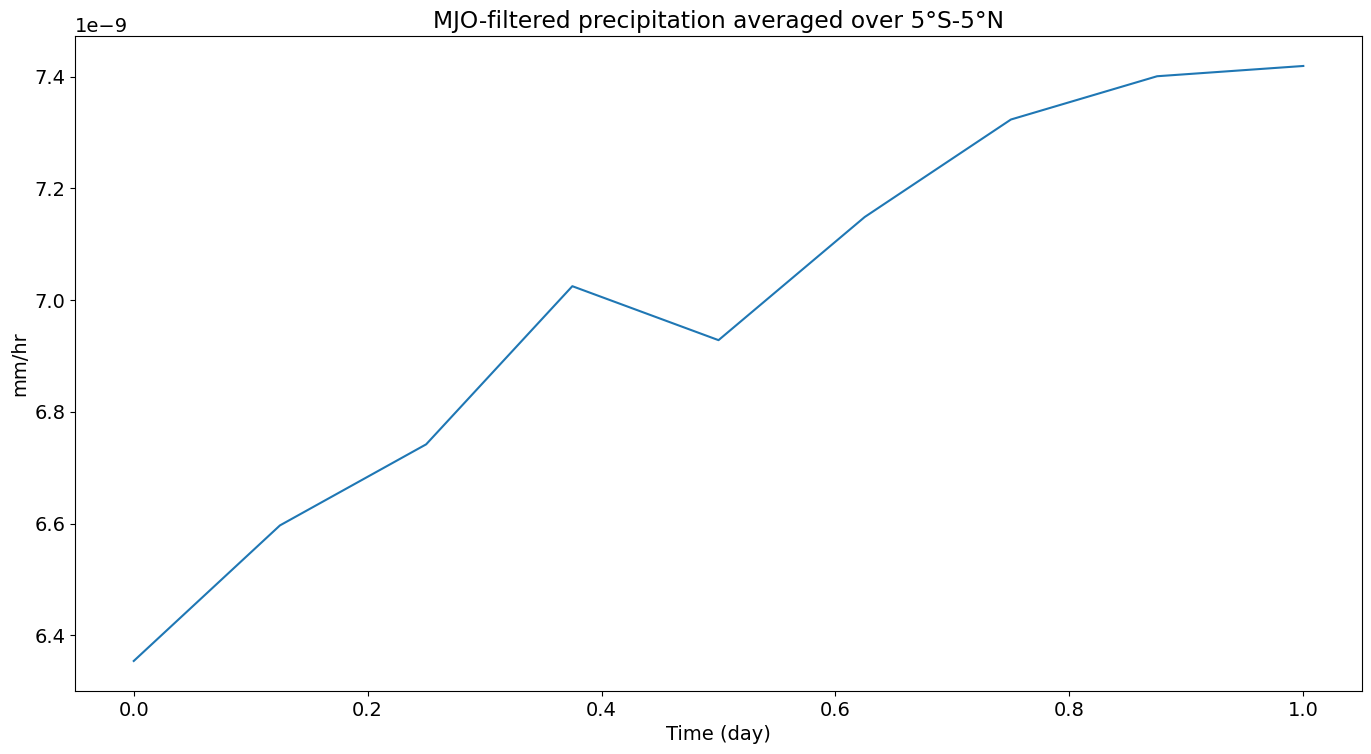

In [59]:
plt.style.use('default')
plt.rcParams.update({'font.size':14})
[fig, ax] = plt.subplots(1, 1, figsize=(16.6, 8.5))
ax.set_title('MJO-filtered precipitation averaged over 5°S-5°N')
ax.plot(
    time/24,
    (1000/3600)*near_equatorial_mjo_precipitation
)
ax.set_xlabel('Time (day)')
ax.set_ylabel('mm/hr')
plt.show()
# plt.savefig(
#     f"{output_file_directory}/mjo_filtered_precipitation.png"
#     bbox_inches='tight',
#     dpi=300
# )

# Calculate anomalies

In [60]:
print(f"Calculating anomalies...")
large_scale_precipitation_anomaly = large_scale_precipitation - large_scale_precipitation.mean(dim='time')
convective_precipitation_anomaly = convective_precipitation - convective_precipitation.mean(dim='time')
column_MSE_anomaly = column_MSE - column_MSE.mean(dim='time')
surface_latent_heat_flux_anomaly = surface_latent_heat_flux - surface_latent_heat_flux.mean(dim='time')
temperature_anomaly = temperature - temperature.mean(dim='time')
upper_level_zonal_velocity_anomaly = upper_level_zonal_velocity - upper_level_zonal_velocity.mean(dim='time')
upper_level_meridional_velocity_anomaly = upper_level_meridional_velocity - upper_level_meridional_velocity.mean(dim='time')
upper_level_geopotential_height_anomaly = upper_level_geopotential_height - upper_level_geopotential_height.mean(dim='time')
lower_level_zonal_velocity_anomaly = lower_level_zonal_velocity - lower_level_zonal_velocity.mean(dim='time')
lower_level_meridional_velocity_anomaly = lower_level_meridional_velocity - lower_level_meridional_velocity.mean(dim='time')
lower_level_geopotential_height_anomaly = lower_level_geopotential_height - lower_level_geopotential_height.mean(dim='time')
print("Anomalies calculated")
print("===============================================")

Calculating anomalies...
Anomalies calculated


# Regress fields onto MJO index

In [61]:
print("Regressing fields...")
# Precipitation
large_scale_precipitation_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    large_scale_precipitation_anomaly
) / len(time) 

# Column MSE
column_MSE_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    column_MSE_anomaly
) / len(time)

# Surface latent heat flux
surface_latent_heat_flux_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    surface_latent_heat_flux_anomaly
) / len(time)

# 200-hPa U
upper_level_zonal_velocity_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    upper_level_zonal_velocity_anomaly
) / len(time)

# 200-hPa V
upper_level_meridional_velocity_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    upper_level_meridional_velocity_anomaly
) / len(time)

# 200-hPa Z
upper_level_geopotential_height_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    upper_level_geopotential_height_anomaly
) / len(time)

# 850-hPa U
lower_level_zonal_velocity_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    lower_level_zonal_velocity_anomaly
) / len(time)

# 850-hPa V
lower_level_meridional_velocity_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    lower_level_meridional_velocity_anomaly
) / len(time)

# 850-hPa Z
lower_level_geopotential_height_anomaly_regressed = np.einsum(
    'i,ikl',
    normalized_near_equatorial_mjo_precipitation,
    lower_level_geopotential_height_anomaly
) / len(time)
print("Fields regressed")

Regressing fields...
Fields regressed


## Plot regressed fields

### Precipitation

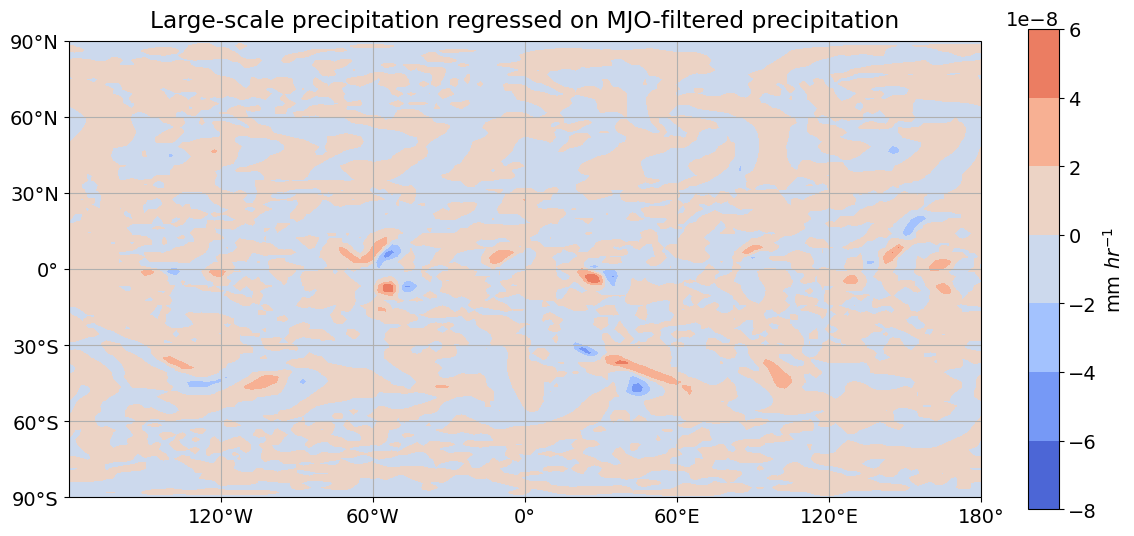

In [97]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(1, 2, width_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

gs_maps = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])


# Add an axis for the initial condition
proj = ccrs.PlateCarree()
ax = fig.add_subplot(gs_maps[0], projection=proj)
ax.set_title('Large-scale precipitation regressed on MJO-filtered precipitation', pad=10)
cbar_ax = fig.add_subplot(gs_cbar[5:-5])

[cdata, clon] = cutil.add_cyclic_point(
    data = (1000/3600)*large_scale_precipitation_anomaly_regressed,
    coord=longitude
)

CS = ax.contourf(
    clon,
    latitude,
    cdata,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    norm=mcolors.CenteredNorm()
)
cbar = plt.colorbar(CS, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'mm $hr^{-1}$')

ax.set_aspect('equal')
ax.gridlines()
ax.set_xticks(ticks=np.arange(-120, 240, 60))
ax.set_xticklabels(labels=tick_labeller(np.arange(-120, 240, 60), 'lon'))
ax.set_yticks(ticks=np.arange(-90, 90+30, 30))
ax.set_yticklabels(labels=tick_labeller(np.arange(-90, 90+30, 30), 'lat'))

plt.show()
# plt.savefig(
#    f"{output_file_directory}/large_scale_precipitation_regression_map.png",
#     bbox_inches='tight',
#     dpi=300
# )

### Column MSE

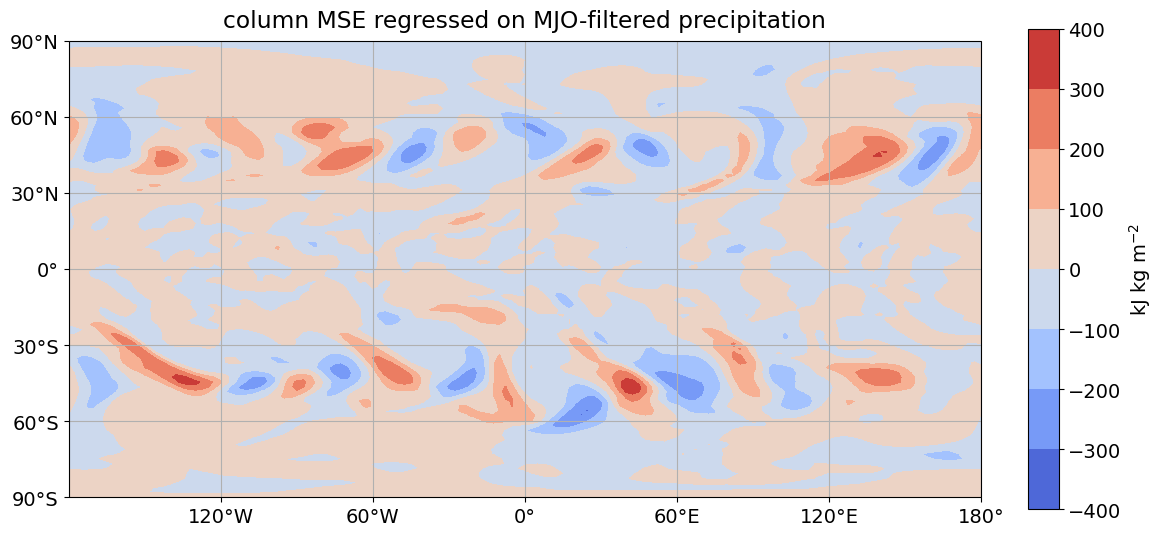

In [126]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(1, 2, width_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

gs_maps = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])


# Add an axis for the initial condition
proj = ccrs.PlateCarree()
ax = fig.add_subplot(gs_maps[0], projection=proj)
ax.set_title('column MSE regressed on MJO-filtered precipitation', pad=10)
cbar_ax = fig.add_subplot(gs_cbar[5:-5])

[cdata, clon] = cutil.add_cyclic_point(
    data = column_MSE_anomaly_regressed/1000,
    coord=longitude
)

CS = ax.contourf(
    clon,
    latitude,
    cdata,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    norm=mcolors.CenteredNorm()
)
cbar = plt.colorbar(CS, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'kJ kg m$^{-2}$')

ax.set_aspect('equal')
ax.gridlines()
ax.set_xticks(ticks=np.arange(-120, 240, 60))
ax.set_xticklabels(labels=tick_labeller(np.arange(-120, 240, 60), 'lon'))
ax.set_yticks(ticks=np.arange(-90, 90+30, 30))
ax.set_yticklabels(labels=tick_labeller(np.arange(-90, 90+30, 30), 'lat'))

plt.show()
# plt.savefig(
#     f"{output_file_directory}/column_MSE_regression_map.png",
#     bbox_inches='tight',
#     dpi=300
# )

### Surface Evaporation

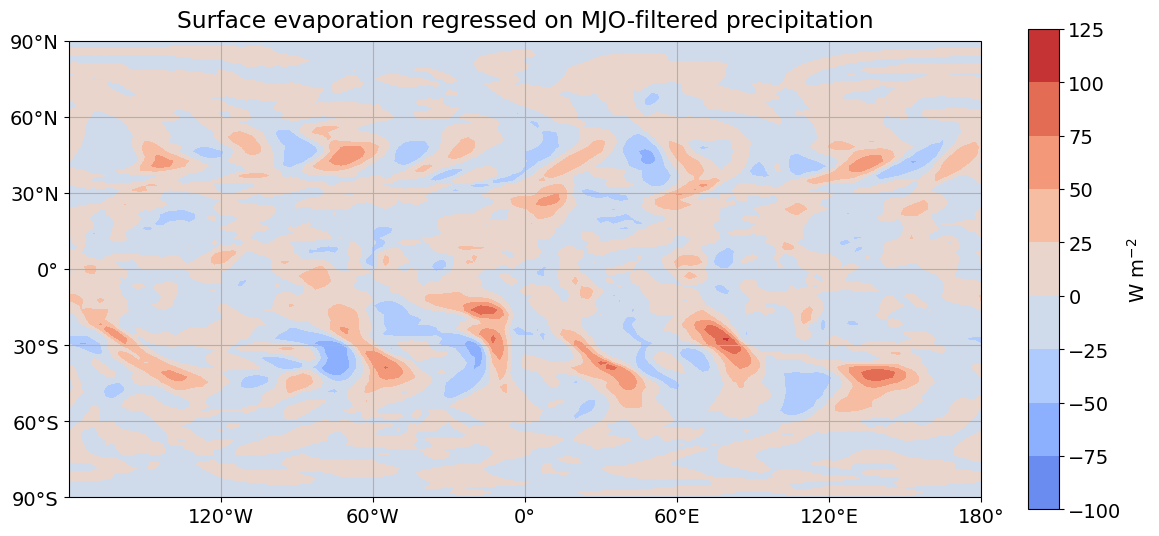

In [127]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(1, 2, width_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

gs_maps = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])


# Add an axis for the initial condition
proj = ccrs.PlateCarree()
ax = fig.add_subplot(gs_maps[0], projection=proj)
ax.set_title('Surface evaporation regressed on MJO-filtered precipitation', pad=10)
cbar_ax = fig.add_subplot(gs_cbar[5:-5])

[cdata, clon] = cutil.add_cyclic_point(
    data = surface_latent_heat_flux_anomaly_regressed,
    coord=longitude
)

CS = ax.contourf(
    clon,
    latitude,
    cdata,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    norm=mcolors.CenteredNorm()
)
cbar = plt.colorbar(CS, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'W m$^{-2}$')

ax.set_aspect('equal')
ax.gridlines()
ax.set_xticks(ticks=np.arange(-120, 240, 60))
ax.set_xticklabels(labels=tick_labeller(np.arange(-120, 240, 60), 'lon'))
ax.set_yticks(ticks=np.arange(-90, 90+30, 30))
ax.set_yticklabels(labels=tick_labeller(np.arange(-90, 90+30, 30), 'lat'))

# plt.show()
plt.savefig(
    f"{output_file_directory}/surface_latent_heat_flux_regression_map.png",
    bbox_inches='tight',
    dpi=300
)

# 850 hPa U, V, Z

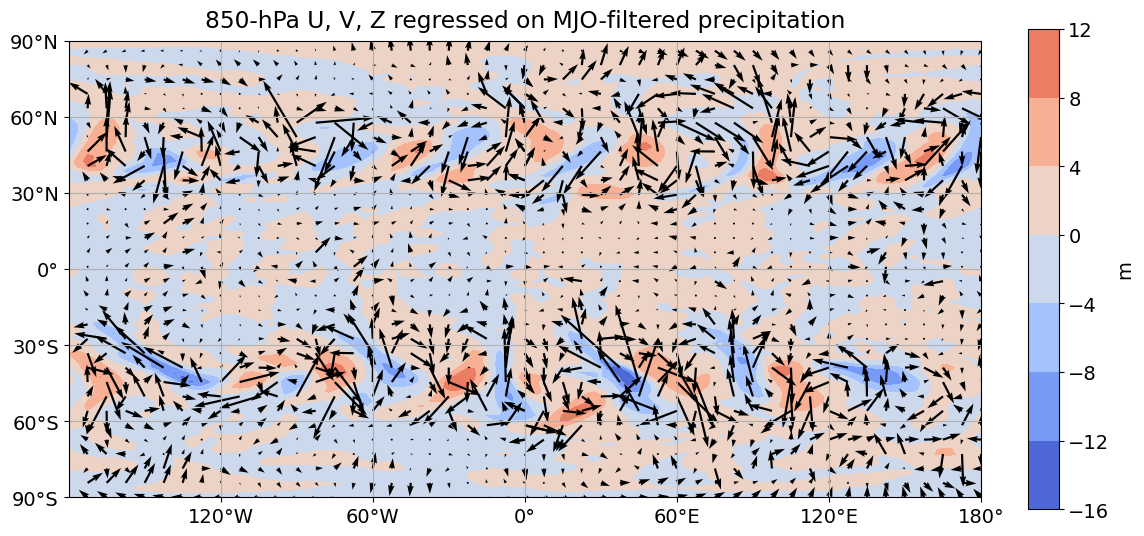

In [120]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(1, 2, width_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

gs_maps = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])


# Add an axis for the initial condition
proj = ccrs.PlateCarree()
ax = fig.add_subplot(gs_maps[0], projection=proj)
ax.set_title('850-hPa U, V, Z regressed on MJO-filtered precipitation', pad=10)
cbar_ax = fig.add_subplot(gs_cbar[5:-5])

[cdata_Z, clon] = cutil.add_cyclic_point(
    data = lower_level_geopotential_height_anomaly_regressed,
    coord=longitude
)

CS = ax.contourf(
    clon,
    latitude,
    cdata_Z,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    norm=mcolors.CenteredNorm()
)
cbar = plt.colorbar(CS, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'm')

[cdata_u, clon] = cutil.add_cyclic_point(
    data = lower_level_zonal_velocity_anomaly_regressed,
    coord=longitude
)

[cdata_v, clon] = cutil.add_cyclic_point(
    data = lower_level_meridional_velocity_anomaly_regressed,
    coord=longitude
)

quiv = ax.quiver(
    clon[::3],
    latitude[::3],
    cdata_u[::3, ::3],
    cdata_v[::3, ::3]
)

ax.set_aspect('equal')
ax.gridlines()
ax.set_xticks(ticks=np.arange(-120, 240, 60))
ax.set_xticklabels(labels=tick_labeller(np.arange(-120, 240, 60), 'lon'))
ax.set_yticks(ticks=np.arange(-90, 90+30, 30))
ax.set_yticklabels(labels=tick_labeller(np.arange(-90, 90+30, 30), 'lat'))

plt.show()
# plt.savefig(
#     f"{output_file_directory}/850hPa_UVZ_regression_map.png",
#     bbox_inches='tight',
#     dpi=300
# )

# 200-hPa U, V, Z

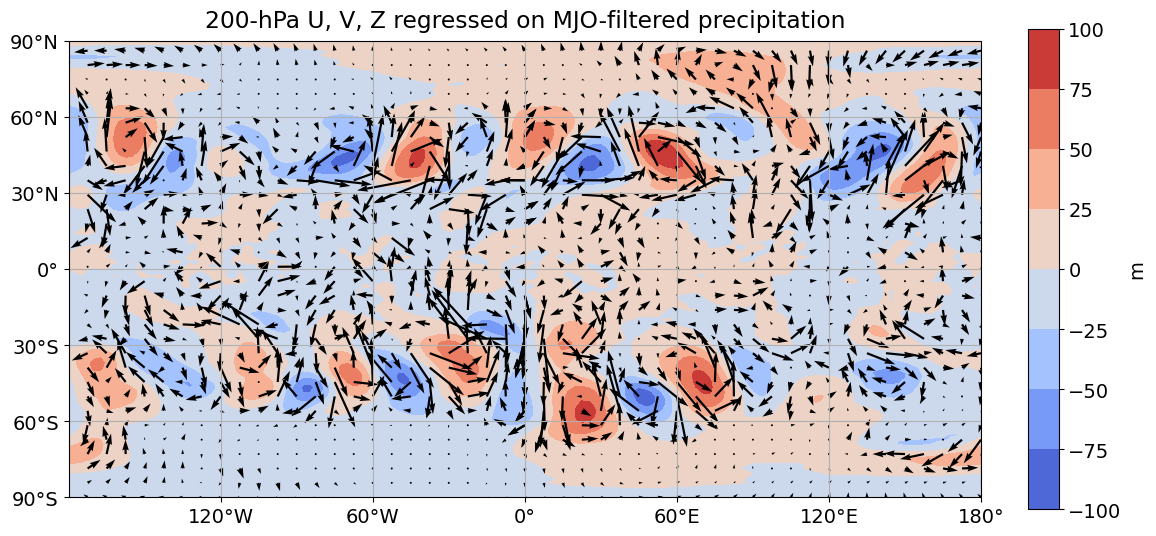

In [119]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(1, 2, width_ratios = [30,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

gs_maps = gs.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(30, 1, subplot_spec=gs_main[1])


# Add an axis for the initial condition
proj = ccrs.PlateCarree()
ax = fig.add_subplot(gs_maps[0], projection=proj)
ax.set_title('200-hPa U, V, Z regressed on MJO-filtered precipitation', pad=10)
cbar_ax = fig.add_subplot(gs_cbar[5:-5])

[cdata_Z, clon] = cutil.add_cyclic_point(
    data = upper_level_geopotential_height_anomaly_regressed,
    coord=longitude
)

CS = ax.contourf(
    clon,
    latitude,
    cdata_Z,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    norm=mcolors.CenteredNorm()
)
cbar = plt.colorbar(CS, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'm')

[cdata_u, clon] = cutil.add_cyclic_point(
    data = upper_level_zonal_velocity_anomaly_regressed,
    coord=longitude
)

[cdata_v, clon] = cutil.add_cyclic_point(
    data = upper_level_meridional_velocity_anomaly_regressed,
    coord=longitude
)

quiv = ax.quiver(
    clon[::3],
    latitude[::3],
    cdata_u[::3, ::3],
    cdata_v[::3, ::3]
)

ax.set_aspect('equal')
ax.gridlines()
ax.set_xticks(ticks=np.arange(-120, 240, 60))
ax.set_xticklabels(labels=tick_labeller(np.arange(-120, 240, 60), 'lon'))
ax.set_yticks(ticks=np.arange(-90, 90+30, 30))
ax.set_yticklabels(labels=tick_labeller(np.arange(-90, 90+30, 30), 'lat'))

plt.show()
# plt.savefig(
#     f"{output_file_directory}/200hPa_UVZ_regression_map.png",
#     bbox_inches='tight',
#     dpi=300
# )

# Column Budget analysis